# Word2Vec

## Будем получать эмбеддинги для слов с помощью CBOW 
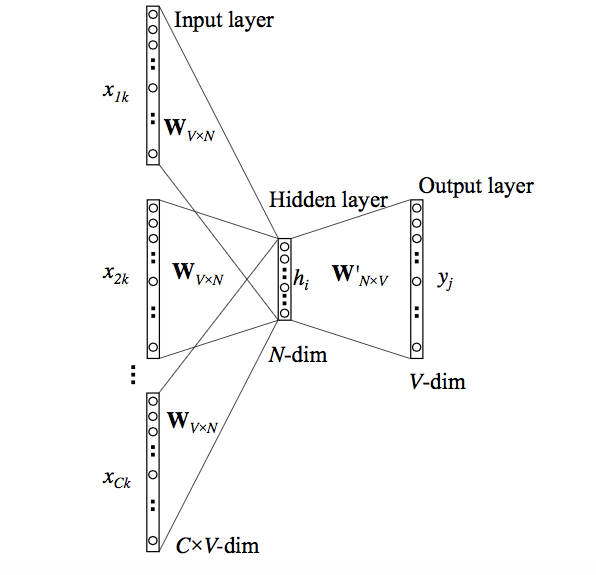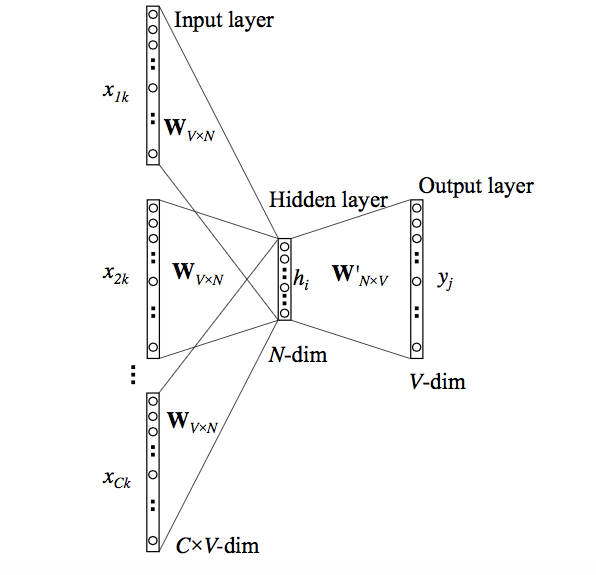

Embedding layer size is (vocab_size, 300)

In [1]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import copy
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import  word_tokenize
nltk.download('punkt')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
text = pd.read_csv('inetensive_1.csv')
text.head()

,Unnamed: 0,text,label
0,0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,4,"Oil prices soar to all-time record, posing new...",2


In [3]:
#Preprocessing the text data
sentences = []
word_set = []

for i in tqdm(range(len(text))):
    x = [i.lower() for  i in word_tokenize(text['text'][i]) if i.isalpha()]
    sentences.append(x)
    for word in x:
        if word not in word_set:
            word_set.append(word)



#Set of vocab
word_set = set(word_set)

100%|██████████| 120000/120000 [05:44<00:00, 348.22it/s]


In [4]:
index_dict = {} #Dictionary to store index for each word
i = 0
for word in tqdm(word_set):
    index_dict[word] = i
    i += 1

100%|██████████| 59995/59995 [00:00<00:00, 1869657.99it/s]


In [5]:
vocab_len = len(index_dict)
vocab_len

59995

## Оконная функция

окно, например, два слева два справа, смотрим контекст, центральное будет таргетом (в середине будет с двух сторон по два слова при размере окна 2, у краевых слов может быть только с одной стороны контекст). Обязательно в рамках предложений, иначе контекст мог бы только портить

In [6]:
def windowizer(sent, wsize=2):  # format of (target, [context])
    row = []
    out = []
    for i, wd in enumerate(sent):
        target = index_dict[wd]

        window = [i+j for j in
                  range(-wsize, wsize+1, 1)
                  if (i+j>=0) &
                     (i+j<len(sent)) &
                     (j!=0)]
        # out.append(target)
        out.append((target,[index_dict[sent[w]] for w in window]))
    row+=out
    return row

In [7]:
w = windowizer(sentences[1])
w[:5]

[(12658, [33753, 18605]),
 (33753, [12658, 18605, 18691]),
 (18605, [12658, 33753, 18691, 2606]),
 (18691, [33753, 18605, 2606, 28351]),
 (2606, [18605, 18691, 28351, 28351])]

In [9]:
dataset = []
for sent in sentences:
  dataset += windowizer(sent)

In [10]:
dataset[:5]

[(1527, [51995, 19087]),
 (51995, [1527, 19087, 30729]),
 (19087, [1527, 51995, 30729, 7844]),
 (30729, [51995, 19087, 7844, 34030]),
 (7844, [19087, 30729, 34030, 33146])]

In [11]:
dataset[1][0]

51995

In [12]:
embedding = np.zeros((len(index_dict)), dtype=np.uint8)
embedding

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [13]:
embedding = np.zeros((len(index_dict)), dtype=np.uint8)
for idxs in (dataset[1][1]):
  embedding[idxs] = 1

In [14]:
sum(embedding)

3

## У сэмпла из Датасета будут лежать one-hot закодированные контекст и таргет. Размерность каждого = длина словаря

In [15]:
from torch.utils.data import Dataset, DataLoader

In [16]:
class CbowDataset(Dataset):

    def __init__(self, dataset, vocab_size=vocab_len):
        self.dataset = dataset
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # dataset[idx]
        target = np.zeros((self.vocab_size), dtype=np.uint8)
        target[dataset[idx][0]] = 1
        context = np.zeros((self.vocab_size), dtype=np.uint8)
        for i in (dataset[idx][1]):
          context[i] = 1
        sample = {'context': context, 'target': target}
        return sample


In [17]:
cbow_dataset = CbowDataset(dataset, len(index_dict))

In [18]:
# 4308301-3446640

In [19]:
cbow_dataset[1]

{'context': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'target': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)}

In [20]:
sum(cbow_dataset[1]['context'])

3

In [21]:
sum(cbow_dataset[1]['target'])

1

In [22]:
len(cbow_dataset)

4308298

## Разбиение данных на train/valid и батчи

In [23]:
train_set, val_set = torch.utils.data.random_split(cbow_dataset, [3446638, 861660])

In [24]:
train_dataloader = DataLoader(train_set, batch_size=2**12,
                        shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_set, batch_size=2**8,
                        shuffle=False, num_workers=4)


In [25]:
dataloaders = {}
dataloaders['train'] = train_dataloader
dataloaders['val'] = val_dataloader
dataset_sizes = {}
dataset_sizes['train'] = len(train_set)
dataset_sizes['val'] = len(val_set)

## CBOW архитектура нейросети

### Возможен вариант с nn.Embedding слоем, куда надо подавать индексы, а не one-hot

In [27]:
# вариант с nn.Embedding 
# class Word2Vec(torch.nn.Module):
#     def __init__(self, vocab_size=vocab_len, hidden_size=300):
#         super().__init__()
#         self.hidden = torch.nn.Embedding(vocab_size, hidden_size)
#         self.linear = torch.nn.Linear(hidden_size, vocab_size, bias=False)


#     def forward(self, input):
        
#         x = self.hidden(input)
#         x = x.mean(axis=1)
#         x = self.linear(x)
#         return x


### Но мы используем nn.Linear, т.к. данные уже в виде one-hot

In [28]:
class Word2Vec(torch.nn.Module):
    def __init__(self, vocab_size=vocab_len, hidden_size=300):
        super().__init__()
        self.hidden = torch.nn.Linear(vocab_size, hidden_size, bias=False)
        self.linear = torch.nn.Linear(hidden_size, vocab_size, bias=False)


    def forward(self, input):

        x = self.hidden(input)
        x = self.linear(x)
        return x
    def encode(self, input):
        x = self.hidden(input)
        return x

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [30]:
model = Word2Vec()
model.to(device)

Word2Vec(
  (hidden): Linear(in_features=59995, out_features=300, bias=False)
  (linear): Linear(in_features=300, out_features=59995, bias=False)
)

### Гиперпараметры

In [31]:
lr = 1e-3
momentum=0.9
epochs = 20

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

### Обучение

In [37]:
def train_model(model, criterion=criterion, optimizer=optimizer, num_epochs=epochs):
    train_losses = []
    val_losses = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
#             running_corrects = 0

            for sample in tqdm(dataloaders[phase]):
                inputs = sample['context'].to(device)
                labels = sample['target'].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.to(torch.float))
                    loss = criterion(outputs, labels.to(torch.float))
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(torch.argmax(outputs) == torch.argmax(labels))

            epoch_loss = running_loss / dataset_sizes[phase]
            # epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            if phase == 'val':
                val_losses.append(epoch_loss)
                if epoch_loss <= best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_losses.append(epoch_loss)


        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model, best_loss, train_losses, val_losses

In [ ]:
best_model, best_loss, train_losses, val_losses = train_model(model)



Epoch 0/19
----------


100%|██████████| 842/842 [03:53<00:00,  3.61it/s]


train Loss: 7.0712


100%|██████████| 3366/3366 [00:56<00:00, 59.30it/s]


val Loss: 6.1388

Epoch 1/19
----------


100%|██████████| 842/842 [03:53<00:00,  3.60it/s]


train Loss: 5.6679


100%|██████████| 3366/3366 [00:57<00:00, 58.67it/s]


val Loss: 5.5481

Epoch 2/19
----------


100%|██████████| 842/842 [03:56<00:00,  3.56it/s]


train Loss: 5.0934


100%|██████████| 3366/3366 [00:56<00:00, 59.34it/s]


val Loss: 5.2977

Epoch 3/19
----------


100%|██████████| 842/842 [03:54<00:00,  3.59it/s]


train Loss: 4.7201


100%|██████████| 3366/3366 [00:57<00:00, 58.90it/s]


val Loss: 5.1669

Epoch 4/19
----------


100%|██████████| 842/842 [03:55<00:00,  3.58it/s]


train Loss: 4.4369


100%|██████████| 3366/3366 [00:57<00:00, 58.93it/s]


val Loss: 5.0951

Epoch 5/19
----------


 25%|██▌       | 211/842 [00:58<02:53,  3.63it/s]

## Результаты обучения

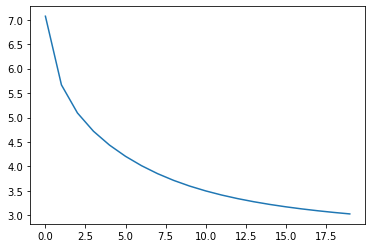

In [42]:
plt.plot(train_losses)

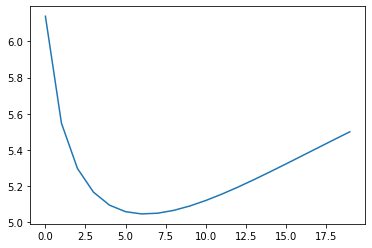

In [43]:
plt.plot(val_losses)

In [ ]:
torch.save(best_model.state_dict(), 'model_w2v.pth')

In [45]:
best_loss

5.046681532844197

In [46]:
model.eval()

Word2Vec(
  (hidden): Linear(in_features=59995, out_features=300, bias=False)
  (linear): Linear(in_features=300, out_features=59995, bias=False)
)

### Контекст для слова 'of'

In [52]:
out = model(torch.Tensor(cbow_dataset[898987]['context']).to(device))

In [53]:
out_indeces = np.argsort(out.cpu().detach().numpy())[::-1][:25]

In [54]:
for search_key in out_indeces:
  for word, key in index_dict.items():
      if key == search_key:
          print(word)

and
of
in
with
for
to
on
system
through
during
as
from
over
management
get
is
that
into
cost
at
make
company
or
support
without


In [57]:
search_key = np.argmax(cbow_dataset[898987]['target'])

In [361]:
for word, key in index_dict.items():
    if key == search_key:
        print(word)

of


#### Представление в скрытом слое данного слова

In [63]:
model.encode(torch.Tensor(cbow_dataset[898987]['target']).to(device))

tensor([-0.3194, -0.0781,  0.3311,  0.2500, -0.5019,  0.0202, -0.2048,  0.1438,
        -0.0308,  0.0315,  0.3211,  0.1824, -0.0348, -0.0145,  0.0120,  0.0044,
        -0.1473,  0.0706,  0.1687,  0.0206,  0.2076,  0.0435, -0.1000, -0.1998,
        -0.2298, -0.0528, -0.1199,  0.1022, -0.0776, -0.1218, -0.1585, -0.0396,
         0.5004, -0.0101, -0.1348,  0.1811, -0.1543, -0.1486,  0.0446, -0.1485,
        -0.1111, -0.0834,  0.0713, -0.2648, -0.1324, -0.0861,  0.2615,  0.3519,
        -0.0048,  0.1831, -0.0981, -0.2742, -0.3387, -0.1496, -0.1015,  0.0142,
        -0.0584,  0.0674,  0.0335, -0.2298,  0.0312, -0.0586, -0.1847,  0.0378,
         0.1507,  0.2210, -0.1648,  0.2191,  0.1821,  0.4333, -0.0095, -0.2969,
         0.0974,  0.0640,  0.1175,  0.1225, -0.1333, -0.0271,  0.0677, -0.4057,
         0.0142, -0.1109, -0.0487, -0.0185,  0.1187, -0.0470,  0.0507,  0.0402,
         0.2157, -0.0117, -0.1488, -0.1217,  0.1910,  0.2228,  0.1986,  0.1912,
        -0.0358, -0.2562, -0.3592, -0.02

In [364]:
id2tok = dict(enumerate(word_set))

## Inference

### Будем считать косинусные расстояние, чтобы смотреть ближайшие слова по контексту

In [64]:
wordvecs = model.linear.weight.cpu().detach().numpy()
tokens = ['good', 'father', 'school', 'hate']


In [72]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    idx = index_dict[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

In [ ]:
dmat = get_distance_matrix(wordvecs, 'cosine')


In [130]:
wordvecs.shape

(59995, 300)

In [75]:
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

good ['bad', 'better', 'positive', 'best', 'simple', 'difficult', 'lucky', 'headlines', 'sure', 'solid'] 

father ['son', 'husband', 'daughter', 'mother', 'recipient', 'autobiography', 'colleague', 'portrait', 'friend', 'predecessor'] 

school ['teachers', 'tragedy', 'schools', 'town', 'commandos', 'church', 'russia', 'jets', 'hearts', 'company'] 

hate ['liar', 'purveyors', 'clogs', 'rocker', 'advise', 'transnational', 'qui', 'virii', 'swoops', 'convict'] 



In [303]:
get_k_similar_words('king', dmat)

[(23811, 'ascended', 0.6263747409057054),
 (10970, 'monarch', 0.6274749884660479),
 (47798, 'gustaf', 0.6457156889185767),
 (6137, 'dancer', 0.6732183974841426),
 (621, 'throne', 0.7134248435099957),
 (45027, 'enzon', 0.7174322782321756),
 (8037, 'basheer', 0.7308761029677215),
 (9918, 'amman', 0.7324373211698257),
 (56579, 'badawi', 0.7412418577421584),
 (39065, 'norodom', 0.7475253900591954)]

In [261]:
wordvecs.shape

(59995, 300)

## Можно поиграться с сложением/вычитанием векторов

In [287]:
new_vec = wordvecs[index_dict['ipo']] + wordvecs[index_dict['usa']] 

In [288]:
new_vec_n = F.normalize(torch.from_numpy(new_vec), p=2, dim=-1)
wordvecs_n = F.normalize(torch.from_numpy(wordvecs), p=2, dim=-1)

In [302]:
torch.norm(wordvecs_n, dim=-1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

In [289]:
import torch.nn.functional as F

In [290]:
output = F.cosine_similarity((new_vec_n), (wordvecs_n))

In [291]:
output.shape

torch.Size([59995])

In [292]:
top_k_sim, top_k_ind = torch.topk(output, k=20)

In [293]:
for t in top_k_ind:
    print(id2tok[t.item()])

ipo
usa
flotation
adwords
conoco
initial
dreamworks
stock
skg
debut
value
incredibles
pixar
openworld
gbrowser
leaseholder
orbitz
playboy
unicom
nastech


## Переведем каждое слово в предложении в embedding c помощью обученных весов и усредним по предложением, получится датасет - (sentences_number, hidden_dim) 

In [307]:
encode_wecs = model.hidden.weight.cpu().detach().numpy()


In [309]:
encode_wecs.shape

(300, 59995)

In [349]:
sent_vecs = []

for sent in tqdm(sentences):
    encoded_lst = []
    for word in sent:
        word_vec = np.zeros((len(index_dict)), dtype=np.uint8)
        word_vec[index_dict[word]] = 1
        encoded = encode_wecs @ word_vec
        encoded_lst.append(encoded)
#     print(np.array(encoded_lst).shape)   
    sent_vecs.append(np.mean(np.array(encoded_lst), axis=0))
    
    
    
    
        


100%|██████████| 120000/120000 [56:48<00:00, 35.20it/s] 


In [350]:
np.array(sent_vecs).shape

(120000, 300)

## Теперь обучим на 

In [351]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [352]:
X_train, X_test, y_train, y_test = train_test_split(
    sent_vecs, text['label'], test_size = 0.25, random_state=42
)


logit = LogisticRegression(random_state=42)

In [353]:
logit.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [354]:
y_pred = logit.predict(X_test)

In [355]:
y_pred_proba = logit.predict_proba(X_test)

In [356]:
accuracy_score(y_test, y_pred)

0.8874

In [357]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.9761478672340616